In [1]:
import numpy as np
from source.pipeline import (
    stepwise_feature_selection,
    make_dataset, make_pipeline,
    marginal_screening, union, extract_features, lasso,
    intersection, mean_value_imputation, cook_distance, remove_outliers,
    definite_regression_imputation, dffits
    )

In [2]:
# definition of pipeline option1
def option1():
    X, y = make_dataset()
    y = mean_value_imputation(X, y)

    O = cook_distance(X, y, 3.0)
    X, y = remove_outliers(X, y, O)

    M = marginal_screening(X, y, 5)
    X = extract_features(X, M)

    M1 = stepwise_feature_selection(X, y, 3)
    M2 = lasso(X, y, 0.08)
    M = union(M1, M2)
    return make_pipeline(output=M)

def option2():
    X, y = make_dataset()
    y = definite_regression_imputation(X, y)

    M = marginal_screening(X, y, 7)
    X = extract_features(X, M)

    O = dffits(X, y, 2.0)
    X, y = remove_outliers(X, y, O)

    M1 = stepwise_feature_selection(X, y, 5)
    M2 = lasso(X, y, 0.05)
    M = intersection(M1, M2)
    return make_pipeline(output=M)


pipeline = option2()
print(pipeline) # print the pipeline structure
print()

# apply the defined pipeline to a actual dataset
n, p = 100, 10
rng = np.random.default_rng(0)

X = rng.normal(size=(n, p))
y = rng.normal(size=n)

M, O = pipeline(X, y) # pipeline can be used as a function
print('selected features:', M)
print('detected outliers:', O)


start -> definite_regression_imputation_0
definite_regression_imputation_0 -> marginal_screening_0
marginal_screening_0 -> extract_0
extract_0 -> dffits_0
dffits_0 -> remove_0
remove_0 -> lasso_0
remove_0 -> stepwise_feature_selection_0
lasso_0 -> intersection_0
stepwise_feature_selection_0 -> intersection_0
intersection_0 -> end

selected features: [0, 1, 2, 4, 9]
detected outliers: [19, 25, 48, 51, 59, 64, 74, 77, 90, 94, 95]


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [10:54<00:00,  3.06it/s]


parametric: 0.056
naive: 0.210


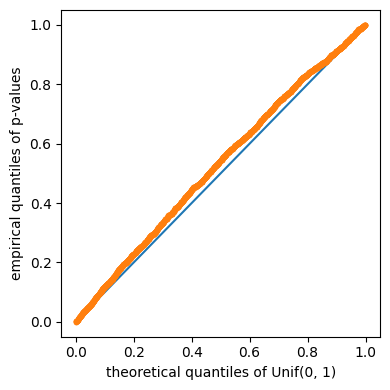

KS: 0.000
search count: 19.82


In [3]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
from sicore import pvalues_qqplot
from scipy.stats import kstest


n, p = 100, 10
rng = np.random.default_rng(1728534388464)
results  = []
for _ in tqdm(range(2000)):
    X = rng.normal(size=(n, p))
    y = rng.normal(size=(n,))
    y[[1, 2, 3, 4, 5]] += 4
    missing = rng.choice(list(range(n)), size=n // 10, replace=False)
    y[missing] = np.nan
    M, O = pipeline(X, y)

    try:
        index = rng.integers(0, len(M))
        _, result = pipeline.inference(X, y, 1.0, index, step=1e-6)
        results.append(result)
    except Exception as e:
        print(e)
        continue

p_list = np.array([result.p_value for result in results])
naive_p_list = np.array([2 * norm.cdf(-np.abs(result.stat)) for result in results])

print(f'parametric: {np.mean(p_list < 0.05):.3f}')
print(f'naive: {np.mean(naive_p_list < 0.05):.3f}')

pvalues_qqplot(p_list)
print(f'KS: {kstest(p_list, "uniform")[1]:.3f}')

print(f'search count: {np.mean([result.search_count for result in results]):.2f}')